# Gender diversity in pop music charts

## Import Libraries

In [4]:
import numpy as np
import pandas as pd

import requests
import re
import json
import csv
import os
from dotenv import load_dotenv


import time
from datetime import datetime, timedelta
import locale

from bs4 import BeautifulSoup

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

import musicbrainzngs

### Import .env
for Musicbrainz useragent & Last.fm API key

In [7]:
load_dotenv('../.env')

True

## Hot 100 Billboard (US 1958-2022)

### Import existing Dataset
Downloaded from https://github.com/HipsterVizNinja/random-data/tree/main/Music/hot-100

In [76]:
hot100_df = pd.read_csv('Hot100_HipsterVizNinja.csv', sep=',')

In [77]:
hot100_df.head()

,chart_position,chart_date,song,performer,song_id,instance,time_on_chart,consecutive_weeks,previous_week,peak_position,worst_position,chart_debut,chart_url
0,84,1990-05-05,"""B"" Girls",Young And Restless,"""B"" GirlsYoung And Restless",1.0,1,NaN,NaN,84,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...
1,78,1990-05-12,"""B"" Girls",Young And Restless,"""B"" GirlsYoung And Restless",1.0,2,1.0,84.0,78,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...
2,68,1990-05-19,"""B"" Girls",Young And Restless,"""B"" GirlsYoung And Restless",1.0,3,2.0,78.0,68,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...
3,60,1990-05-26,"""B"" Girls",Young And Restless,"""B"" GirlsYoung And Restless",1.0,4,3.0,68.0,60,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...
4,58,1990-06-02,"""B"" Girls",Young And Restless,"""B"" GirlsYoung And Restless",1.0,5,4.0,60.0,58,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...


In [78]:
hot100_df.tail()

,chart_position,chart_date,song,performer,song_id,instance,time_on_chart,consecutive_weeks,previous_week,peak_position,worst_position,chart_debut,chart_url
336290,99,2001-02-10,www.memory,Alan Jackson,www.memoryAlan Jackson,1.0,15,14.0,89.0,45,99,2000-11-04,https://www.billboard.com/charts/hot-100/2001-...
336291,66,1958-12-13,¿Dònde Està Santa Claus? (Where Is Santa Claus?),Augie Rios,¿Dònde Està Santa Claus? (Where Is Santa Claus...,1.0,1,NaN,NaN,66,66,1958-12-13,https://www.billboard.com/charts/hot-100/1958-...
336292,53,1958-12-20,¿Dònde Està Santa Claus? (Where Is Santa Claus?),Augie Rios,¿Dònde Està Santa Claus? (Where Is Santa Claus...,1.0,2,1.0,66.0,53,66,1958-12-13,https://www.billboard.com/charts/hot-100/1958-...
336293,47,1958-12-27,¿Dònde Està Santa Claus? (Where Is Santa Claus?),Augie Rios,¿Dònde Està Santa Claus? (Where Is Santa Claus...,1.0,3,2.0,53.0,47,66,1958-12-13,https://www.billboard.com/charts/hot-100/1958-...
336294,47,1959-01-03,¿Dònde Està Santa Claus? (Where Is Santa Claus?),Augie Rios,¿Dònde Està Santa Claus? (Where Is Santa Claus...,1.0,4,3.0,47.0,47,66,1958-12-13,https://www.billboard.com/charts/hot-100/1959-...


In [79]:
hot100_df.shape

(336295, 13)

In [80]:
hot100_df.nunique()

chart_position         100
chart_date            3363
song                 25225
performer            10499
song_id              30444
instance                15
time_on_chart           91
consecutive_weeks       89
previous_week          100
peak_position          100
worst_position         100
chart_debut           3344
chart_url             3363
dtype: int64

### Pre-processing

#### Clean 'song_id'

In [81]:
# Concatenate "song" and "performer" columns to create "song_id"
hot100_df['song_id2'] = hot100_df['song'] + '-' + hot100_df['performer']

# Clean the "song_id" values
hot100_df['song_id2'] = hot100_df['song_id2'].str.strip().str.lower()

hot100_df

,chart_position,chart_date,song,performer,song_id,instance,time_on_chart,consecutive_weeks,previous_week,peak_position,worst_position,chart_debut,chart_url,song_id2
0,84,1990-05-05,"""B"" Girls",Young And Restless,"""B"" GirlsYoung And Restless",1.0,1,NaN,NaN,84,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...,"""b"" girls-young and restless"
1,78,1990-05-12,"""B"" Girls",Young And Restless,"""B"" GirlsYoung And Restless",1.0,2,1.0,84.0,78,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...,"""b"" girls-young and restless"
2,68,1990-05-19,"""B"" Girls",Young And Restless,"""B"" GirlsYoung And Restless",1.0,3,2.0,78.0,68,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...,"""b"" girls-young and restless"
3,60,1990-05-26,"""B"" Girls",Young And Restless,"""B"" GirlsYoung And Restless",1.0,4,3.0,68.0,60,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...,"""b"" girls-young and restless"
4,58,1990-06-02,"""B"" Girls",Young And Restless,"""B"" GirlsYoung And Restless",1.0,5,4.0,60.0,58,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...,"""b"" girls-young and restless"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336290,99,2001-02-10,www.memory,Alan Jackson,www.memoryAlan Jackson,1.0,15,14.0,89.0,45,99,2000-11-04,https://www.billboard.com/charts/hot-100/2001-...,www.memory-alan jackson
336291,66,1958-12-13,¿Dònde Està Santa Claus? (Where Is Santa Claus?),Augie Rios,¿Dònde Està Santa Claus? (Where Is Santa Claus...,1.0,1,NaN,NaN,66,66,1958-12-13,https://www.billboard.com/charts/hot-100/1958-...,¿dònde està santa claus? (where is santa claus...
336292,53,1958-12-20,¿Dònde Està Santa Claus? (Where Is Santa Claus?),Augie Rios,¿Dònde Està Santa Claus? (Where Is Santa Claus...,1.0,2,1.0,66.0,53,66,1958-12-13,https://www.billboard.com/charts/hot-100/1958-...,¿dònde està santa claus? (where is santa claus...
336293,47,1958-12-27,¿Dònde Està Santa Claus? (Where Is Santa Claus?),Augie Rios,¿Dònde Està Santa Claus? (Where Is Santa Claus...,1.0,3,2.0,53.0,47,66,1958-12-13,https://www.billboard.com/charts/hot-100/1958-...,¿dònde està santa claus? (where is santa claus...


In [82]:
hot100_df.nunique()

chart_position         100
chart_date            3363
song                 25225
performer            10499
song_id              30444
instance                15
time_on_chart           91
consecutive_weeks       89
previous_week          100
peak_position          100
worst_position         100
chart_debut           3344
chart_url             3363
song_id2             30435
dtype: int64

In [83]:
# Clean the "song_id" values
hot100_df['song_id'] = hot100_df['song_id'].str.strip().str.lower()
hot100_df.nunique()

chart_position         100
chart_date            3363
song                 25225
performer            10499
song_id              30435
instance                15
time_on_chart           91
consecutive_weeks       89
previous_week          100
peak_position          100
worst_position         100
chart_debut           3344
chart_url             3363
song_id2             30435
dtype: int64

In [84]:
# Now we see that song_id2 and song_id have the same value counts. We can drop the original 'song_id' column
hot100_df.drop('song_id', axis=1, inplace=True)

# Rename 'song_id2' as 'song_id'
hot100_df.rename(columns={'song_id2': 'song_id'}, inplace=True)

hot100_df

,chart_position,chart_date,song,performer,instance,time_on_chart,consecutive_weeks,previous_week,peak_position,worst_position,chart_debut,chart_url,song_id
0,84,1990-05-05,"""B"" Girls",Young And Restless,1.0,1,NaN,NaN,84,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...,"""b"" girls-young and restless"
1,78,1990-05-12,"""B"" Girls",Young And Restless,1.0,2,1.0,84.0,78,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...,"""b"" girls-young and restless"
2,68,1990-05-19,"""B"" Girls",Young And Restless,1.0,3,2.0,78.0,68,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...,"""b"" girls-young and restless"
3,60,1990-05-26,"""B"" Girls",Young And Restless,1.0,4,3.0,68.0,60,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...,"""b"" girls-young and restless"
4,58,1990-06-02,"""B"" Girls",Young And Restless,1.0,5,4.0,60.0,58,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...,"""b"" girls-young and restless"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
336290,99,2001-02-10,www.memory,Alan Jackson,1.0,15,14.0,89.0,45,99,2000-11-04,https://www.billboard.com/charts/hot-100/2001-...,www.memory-alan jackson
336291,66,1958-12-13,¿Dònde Està Santa Claus? (Where Is Santa Claus?),Augie Rios,1.0,1,NaN,NaN,66,66,1958-12-13,https://www.billboard.com/charts/hot-100/1958-...,¿dònde està santa claus? (where is santa claus...
336292,53,1958-12-20,¿Dònde Està Santa Claus? (Where Is Santa Claus?),Augie Rios,1.0,2,1.0,66.0,53,66,1958-12-13,https://www.billboard.com/charts/hot-100/1958-...,¿dònde està santa claus? (where is santa claus...
336293,47,1958-12-27,¿Dònde Està Santa Claus? (Where Is Santa Claus?),Augie Rios,1.0,3,2.0,53.0,47,66,1958-12-13,https://www.billboard.com/charts/hot-100/1958-...,¿dònde està santa claus? (where is santa claus...


#### From 'performer', create 'main_artist' and 'artist_featured'

In [85]:
performer_counts = hot100_df['performer'].value_counts()

In [86]:
top_20_performers = performer_counts.head(20)
top_20_performers

Taylor Swift          1180
Elton John             889
Madonna                857
Drake                  832
Kenny Chesney          777
Tim McGraw             739
Keith Urban            674
Stevie Wonder          659
Rod Stewart            657
Mariah Carey           635
Michael Jackson        613
Chicago                607
Rascal Flatts          604
Jason Aldean           592
Billy Joel             588
The Beatles            585
The Rolling Stones     585
Rihanna                575
Aretha Franklin        569
P!nk                   564
Name: performer, dtype: int64

In [87]:
#FUNCTION TO SEPARATE ARTIST WITH "FEAT." INTO MAIN AND FEATURED ARTISTS
 
def clean_artist_features(artist):
    keywords = ['feat', 'feat\.', 'featuring']
    pattern = re.compile(r'|'.join(keywords), re.IGNORECASE)
    parentheses_pattern_main = re.compile(r'\s*\($')
    brackets_pattern_main = re.compile(r'\s*\[$')
    parentheses_pattern_featured = re.compile(r'([^()\[\]]+)\s*[)\]]+$')

    match = re.search(pattern, artist)
    if match:
        cleaned_artist_main = artist[:match.start()].strip()
        cleaned_artist_main = re.sub(parentheses_pattern_main, '', cleaned_artist_main).strip()
        cleaned_artist_main = re.sub(brackets_pattern_main, '', cleaned_artist_main).strip()
        featured_artist = re.sub(pattern, '', artist[match.end():]).strip('. ').lstrip('uring ')
        return cleaned_artist_main, featured_artist
    else:
        return artist, ''

In [88]:
# CALL THE FUNCTION TO CREATE MAIN AND FEATURED ARTISTS COLUMNS AND DISPLAY RESULTS

hot100_df[['main_artist', 'artist_featured']] = hot100_df['performer'].apply(clean_artist_features).apply(pd.Series)

hot100_df

,chart_position,chart_date,song,performer,instance,time_on_chart,consecutive_weeks,previous_week,peak_position,worst_position,chart_debut,chart_url,song_id,main_artist,artist_featured
0,84,1990-05-05,"""B"" Girls",Young And Restless,1.0,1,NaN,NaN,84,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...,"""b"" girls-young and restless",Young And Restless,
1,78,1990-05-12,"""B"" Girls",Young And Restless,1.0,2,1.0,84.0,78,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...,"""b"" girls-young and restless",Young And Restless,
2,68,1990-05-19,"""B"" Girls",Young And Restless,1.0,3,2.0,78.0,68,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...,"""b"" girls-young and restless",Young And Restless,
3,60,1990-05-26,"""B"" Girls",Young And Restless,1.0,4,3.0,68.0,60,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...,"""b"" girls-young and restless",Young And Restless,
4,58,1990-06-02,"""B"" Girls",Young And Restless,1.0,5,4.0,60.0,58,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...,"""b"" girls-young and restless",Young And Restless,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336290,99,2001-02-10,www.memory,Alan Jackson,1.0,15,14.0,89.0,45,99,2000-11-04,https://www.billboard.com/charts/hot-100/2001-...,www.memory-alan jackson,Alan Jackson,
336291,66,1958-12-13,¿Dònde Està Santa Claus? (Where Is Santa Claus?),Augie Rios,1.0,1,NaN,NaN,66,66,1958-12-13,https://www.billboard.com/charts/hot-100/1958-...,¿dònde està santa claus? (where is santa claus...,Augie Rios,
336292,53,1958-12-20,¿Dònde Està Santa Claus? (Where Is Santa Claus?),Augie Rios,1.0,2,1.0,66.0,53,66,1958-12-13,https://www.billboard.com/charts/hot-100/1958-...,¿dònde està santa claus? (where is santa claus...,Augie Rios,
336293,47,1958-12-27,¿Dònde Està Santa Claus? (Where Is Santa Claus?),Augie Rios,1.0,3,2.0,53.0,47,66,1958-12-13,https://www.billboard.com/charts/hot-100/1958-...,¿dònde està santa claus? (where is santa claus...,Augie Rios,


In [15]:
#DISPLAY ONLY ROWS WITH FEAT
hot100_df.loc[hot100_df['performer'].str.contains('feat')]

,chart_position,chart_date,song,performer,instance,time_on_chart,consecutive_weeks,previous_week,peak_position,worst_position,chart_debut,chart_url,song_id,main_artist,artist_featured
1306,94,1964-01-25,(It's No) Sin,The Duprees featuring Joey Vann,1.0,1,NaN,NaN,94,94,1964-01-25,https://www.billboard.com/charts/hot-100/1964-...,(it's no) sin-the duprees featuring joey vann,The Duprees,Joey Vann
1307,82,1964-02-01,(It's No) Sin,The Duprees featuring Joey Vann,1.0,2,1.0,94.0,82,94,1964-01-25,https://www.billboard.com/charts/hot-100/1964-...,(it's no) sin-the duprees featuring joey vann,The Duprees,Joey Vann
1308,74,1964-02-08,(It's No) Sin,The Duprees featuring Joey Vann,1.0,3,2.0,82.0,74,94,1964-01-25,https://www.billboard.com/charts/hot-100/1964-...,(it's no) sin-the duprees featuring joey vann,The Duprees,Joey Vann
1309,88,1964-02-15,(It's No) Sin,The Duprees featuring Joey Vann,1.0,4,3.0,74.0,74,94,1964-01-25,https://www.billboard.com/charts/hot-100/1964-...,(it's no) sin-the duprees featuring joey vann,The Duprees,Joey Vann
1310,84,1964-02-22,(It's No) Sin,The Duprees featuring Joey Vann,1.0,5,4.0,88.0,74,94,1964-01-25,https://www.billboard.com/charts/hot-100/1964-...,(it's no) sin-the duprees featuring joey vann,The Duprees,Joey Vann
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320786,48,1963-09-07,Why Don't You Believe Me,The Duprees featuring Joey Vann,1.0,3,2.0,59.0,48,70,1963-08-24,https://www.billboard.com/charts/hot-100/1963-...,why don't you believe me-the duprees featuring...,The Duprees,Joey Vann
320787,40,1963-09-14,Why Don't You Believe Me,The Duprees featuring Joey Vann,1.0,4,3.0,48.0,40,70,1963-08-24,https://www.billboard.com/charts/hot-100/1963-...,why don't you believe me-the duprees featuring...,The Duprees,Joey Vann
320788,37,1963-09-21,Why Don't You Believe Me,The Duprees featuring Joey Vann,1.0,5,4.0,40.0,37,70,1963-08-24,https://www.billboard.com/charts/hot-100/1963-...,why don't you believe me-the duprees featuring...,The Duprees,Joey Vann
320789,39,1963-09-28,Why Don't You Believe Me,The Duprees featuring Joey Vann,1.0,6,5.0,37.0,37,70,1963-08-24,https://www.billboard.com/charts/hot-100/1963-...,why don't you believe me-the duprees featuring...,The Duprees,Joey Vann


In [16]:
hot100_df['main_artist'].value_counts()
#Now we have only 8423 unique main artists

Drake                            1526
Taylor Swift                     1300
Elton John                        889
Madonna                           885
Rihanna                           885
                                 ... 
Cliff Richard And The Shadows       1
Mina                                1
Zedd & Liam Payne                   1
Ruby Wright                         1
The Quarter Notes                   1
Name: main_artist, Length: 8423, dtype: int64

In [17]:
hot100_df['artist_featured'].value_counts()
#And 1551 unique featured artists

                            302791
Drake                          907
Lil Wayne                      632
Nicki Minaj                    516
Chris Brown                    379
                             ...  
21 Savage & 42 Dugg              1
Sherhonda Gaulden                1
Lil' KeKe                        1
Wale, Tyga & Roscoe Dash         1
Joey Bada$$                      1
Name: artist_featured, Length: 1551, dtype: int64

## Top50 (1984-1998) & Top100 (FR 1998-2020)

### Scrape single charts
*(Crawling and export part #commented below so as not to run again!)*

In [18]:
#DEFINE WEEK_ID LIST USED IN URL

start_year = 1984
end_year = 2020

week_ids = []

for year in range(start_year, end_year + 1):
    if year == start_year:
        start_week = 44  # Starting week for the first year
    else:
        start_week = 1   # Starting week for subsequent years
        
    if year == end_year:
        end_week = 51  # Ending week for the last year
    else:
        end_week = 53  # Ending week for other years

    for week in range(start_week, end_week + 1):
        week_id = "{:02d}{:02d}".format(year % 100, week)
        week_ids.append(week_id)

print(week_ids)

['8444', '8445', '8446', '8447', '8448', '8449', '8450', '8451', '8452', '8453', '8501', '8502', '8503', '8504', '8505', '8506', '8507', '8508', '8509', '8510', '8511', '8512', '8513', '8514', '8515', '8516', '8517', '8518', '8519', '8520', '8521', '8522', '8523', '8524', '8525', '8526', '8527', '8528', '8529', '8530', '8531', '8532', '8533', '8534', '8535', '8536', '8537', '8538', '8539', '8540', '8541', '8542', '8543', '8544', '8545', '8546', '8547', '8548', '8549', '8550', '8551', '8552', '8553', '8601', '8602', '8603', '8604', '8605', '8606', '8607', '8608', '8609', '8610', '8611', '8612', '8613', '8614', '8615', '8616', '8617', '8618', '8619', '8620', '8621', '8622', '8623', '8624', '8625', '8626', '8627', '8628', '8629', '8630', '8631', '8632', '8633', '8634', '8635', '8636', '8637', '8638', '8639', '8640', '8641', '8642', '8643', '8644', '8645', '8646', '8647', '8648', '8649', '8650', '8651', '8652', '8653', '8701', '8702', '8703', '8704', '8705', '8706', '8707', '8708', '8709',

In [19]:
# FUNCTION FOR PARSING THROUGH PAGE CONTENT AND STORING CHART DETAILS

def scrape_chart_details(week_id, FRcharts_df, soup=None, soup2=None):
    if soup2 is not None:
        soup = soup2

    #Create a Dataframe to store the given week info
    week_df = pd.DataFrame(columns=FRcharts_df.columns)

    # Scrape the year and week date
    year_select = soup.find("option", selected=True)
    
    # Handle error if the page for this week ID doesn't exist (Redirection to 404.php page doesn't allow us to catch a 404 response)
    if year_select is None:
        print("Error Week #", week_id, "(year not found)")
        return week_df
    
    year = year_select.text.strip()

    week_select = soup.find("select", attrs={"name": "semaine"})
    week_option = week_select.find("option", selected=True)
    week_date = week_option.text.strip()

    # Scrape the chart details
    chart_data = soup.find_all("div", class_="b572")
    for entry in chart_data:
        try:
            position = entry.find("div", class_="c1_td2").text.strip()
            
            # Find the position evolution in all four possible classes
            position_trends = ["entry", "egal", "up", "down"]
            position_evolution = ""
            for trend in position_trends:
                evolution_elem = entry.find("font", class_=trend)
                if evolution_elem:
                    position_evolution = evolution_elem.text.strip()
                    break #exit the loop after finding the position evolution

            artist = entry.find("font", class_="noir13b").text.strip()
            song_title = entry.find("font", class_="noir11").text.strip()

        except AttributeError:
            print("Error scraping data for an entry. Week #", week_id, " Skipping. Position #", position)

        # Add the scraped data to the week's DataFrame using pd.concat (append will be deprecated from future Pandas version)
        entry_df = pd.DataFrame(
             [[position, position_evolution, artist, song_title, year, week_date, week_id]],
             columns=FRcharts_df.columns)
        week_df = pd.concat([week_df, entry_df], ignore_index=True)

    # Export the week's Dataframe to csv, append the csv if it exists without column names
    # Append the global DF if week is not empty
    if not week_df.empty:
        week_df.to_csv('top50_in_progress.csv', mode='a', header=not os.path.isfile('top50_in_progress.csv')) #index=False, mode: 'w' (overwrite) / 'a' (append)
#        FRcharts_df = pd.concat([FRcharts_df, week_df])     

        # Feedback for Scraping status monitoring
        print("Scraped #", week_id,": ", week_date)

    return week_df

In [20]:
#CRAWLING THROUGH GIVEN PAGES AND RETURNING REQUEST STATUS AND DATAFRAME

#########################################

# COMMENTED OUT SO AS NOT TO CRAWL AGAIN

#########################################

# # Define Dataframe first outside the function
# FRcharts_df = pd.DataFrame(
#     columns=["Position", "Position Evolution", "Artist", "Song Title", "Year", "Week", "URL Week ID"])
#         
# #def scrape_chart_pages(start_week_ID, end_week_ID, FRcharts_df):
# base_url = "https://www.chartsinfrance.net"
# page_statuses = {}  # Dictionary to store page statuses
# 
# for week_id in week_ids:
#     FRcharts_url = f"{base_url}/charts/{week_id}/singles.php"
#     
#     # Send a GET request to the URL and check if it received a response
#     delay = 0.5
#     
#     try:
#         response = requests.get(FRcharts_url)
#         page_statuses[week_id] = response.status_code  # Store the request status in page statuses
#         response.raise_for_status()  # Raise an exception if an HTTP error occurred
#     except requests.exceptions.HTTPError as e:
#         print(f"URL not found: {FRcharts_url}")
#         continue  # Skip to the next iteration of the loop
#     # Parse the HTML content
#     soup = BeautifulSoup(response.content, "html.parser")
# 
#     FRcharts_df = pd.concat([FRcharts_df, scrape_chart_details(week_id, FRcharts_df, soup=soup)])
# 
#     # Check if a second page exists
#     pagination_div = soup.find("div", class_="pagination")
#     if pagination_div:
#         second_page_link = pagination_div.find("a", href=True)
#         if second_page_link:
#             page2_url = base_url + second_page_link["href"]
#             try:
#                 response2 = requests.get(page2_url)
#                 page_statuses[week_id,2] = response2.status_code  # Store the request status in page statuses
#                 response2.raise_for_status()  # Raise an exception if an HTTP error occurred
#                 if response2.status_code == 200:
#                     soup2 = BeautifulSoup(response2.content, "html.parser")
#                     FRcharts_df = pd.concat([FRcharts_df, scrape_chart_details(week_id, FRcharts_df, soup2=soup2)])
#             except requests.exceptions.HTTPError as e:
#                 print(f"URL not found: {page2_url}")
#                 continue  # Skip to the next iteration of the loop
# 
#     time.sleep(delay)
# 
# FRcharts_df.reset_index(drop=True, inplace=True)
# FRcharts_df.index = FRcharts_df.index + 1
# FRcharts_df.to_csv('top50.csv', mode='a', header=not os.path.isfile('top50.csv')) #index=False, mode: 'w' (overwrite) / 'a' (append)

#page_statuses
#FRcharts_df # 152551 rows × 7 columns


### Import scraped French Top 50

In [21]:
FRcharts_df = pd.read_csv('top50.csv', sep=',', index_col=0)

In [22]:
FRcharts_df


,Position,Position Evolution,Artist,Song Title,Year,Week,URL Week ID
1,1,Entrée,Peter et Sloane,"Besoin de rien, envie de toi",1984,Semaine du 26 octobre 1984,8444
2,2,Entrée,Cookie Dingler,Femme libérée,1984,Semaine du 26 octobre 1984,8444
3,3,Entrée,Scorpions,Still Loving You,1984,Semaine du 26 octobre 1984,8444
4,4,Entrée,Chris De Burgh,High On Emotion,1984,Semaine du 26 octobre 1984,8444
5,5,Entrée,Stevie Wonder,I Just Called To Say I Love You,1984,Semaine du 26 octobre 1984,8444
...,...,...,...,...,...,...,...
152547,96,Entrée,Bon Entendeur,Le temps est bon,2020,Semaine du 11 décembre 2020,2051
152548,97,Entrée,Patrick Fiori,Les gens qu'on aime,2020,Semaine du 11 décembre 2020,2051
152549,98,-28,Jean-Louis Murat,Baby Love D.c.,2020,Semaine du 11 décembre 2020,2051
152550,99,Entrée,Barbara Pravi,Voilà,2020,Semaine du 11 décembre 2020,2051


### Pre-processing

#### Create song_id

In [23]:
# Concatenate "song_title" and "artist" columns to create "song_id"
FRcharts_df['song_id'] = FRcharts_df['Song Title'] + '-' + FRcharts_df['Artist']

# Clean the "song_id" values
FRcharts_df['song_id'] = FRcharts_df['song_id'].str.strip().str.lower()

FRcharts_df

,Position,Position Evolution,Artist,Song Title,Year,Week,URL Week ID,song_id
1,1,Entrée,Peter et Sloane,"Besoin de rien, envie de toi",1984,Semaine du 26 octobre 1984,8444,"besoin de rien, envie de toi-peter et sloane"
2,2,Entrée,Cookie Dingler,Femme libérée,1984,Semaine du 26 octobre 1984,8444,femme libérée-cookie dingler
3,3,Entrée,Scorpions,Still Loving You,1984,Semaine du 26 octobre 1984,8444,still loving you-scorpions
4,4,Entrée,Chris De Burgh,High On Emotion,1984,Semaine du 26 octobre 1984,8444,high on emotion-chris de burgh
5,5,Entrée,Stevie Wonder,I Just Called To Say I Love You,1984,Semaine du 26 octobre 1984,8444,i just called to say i love you-stevie wonder
...,...,...,...,...,...,...,...,...
152547,96,Entrée,Bon Entendeur,Le temps est bon,2020,Semaine du 11 décembre 2020,2051,le temps est bon-bon entendeur
152548,97,Entrée,Patrick Fiori,Les gens qu'on aime,2020,Semaine du 11 décembre 2020,2051,les gens qu'on aime-patrick fiori
152549,98,-28,Jean-Louis Murat,Baby Love D.c.,2020,Semaine du 11 décembre 2020,2051,baby love d.c.-jean-louis murat
152550,99,Entrée,Barbara Pravi,Voilà,2020,Semaine du 11 décembre 2020,2051,voilà-barbara pravi


In [24]:
FRcharts_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152551 entries, 1 to 152551
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Position            152551 non-null  int64 
 1   Position Evolution  152551 non-null  object
 2   Artist              152548 non-null  object
 3   Song Title          152548 non-null  object
 4   Year                152551 non-null  int64 
 5   Week                152551 non-null  object
 6   URL Week ID         152551 non-null  int64 
 7   song_id             152548 non-null  object
dtypes: int64(3), object(5)
memory usage: 10.5+ MB


#### From 'Week' to 'chart_date'

In [25]:
# Set the French locale
locale.setlocale(locale.LC_TIME, 'fr_FR.UTF-8')

# Convert the 'Week Date' column to datetime format
FRcharts_df['chart_date'] = pd.to_datetime(FRcharts_df['Week'], format='Semaine du %d %B %Y')

FRcharts_df

,Position,Position Evolution,Artist,Song Title,Year,Week,URL Week ID,song_id,chart_date
1,1,Entrée,Peter et Sloane,"Besoin de rien, envie de toi",1984,Semaine du 26 octobre 1984,8444,"besoin de rien, envie de toi-peter et sloane",1984-10-26
2,2,Entrée,Cookie Dingler,Femme libérée,1984,Semaine du 26 octobre 1984,8444,femme libérée-cookie dingler,1984-10-26
3,3,Entrée,Scorpions,Still Loving You,1984,Semaine du 26 octobre 1984,8444,still loving you-scorpions,1984-10-26
4,4,Entrée,Chris De Burgh,High On Emotion,1984,Semaine du 26 octobre 1984,8444,high on emotion-chris de burgh,1984-10-26
5,5,Entrée,Stevie Wonder,I Just Called To Say I Love You,1984,Semaine du 26 octobre 1984,8444,i just called to say i love you-stevie wonder,1984-10-26
...,...,...,...,...,...,...,...,...,...
152547,96,Entrée,Bon Entendeur,Le temps est bon,2020,Semaine du 11 décembre 2020,2051,le temps est bon-bon entendeur,2020-12-11
152548,97,Entrée,Patrick Fiori,Les gens qu'on aime,2020,Semaine du 11 décembre 2020,2051,les gens qu'on aime-patrick fiori,2020-12-11
152549,98,-28,Jean-Louis Murat,Baby Love D.c.,2020,Semaine du 11 décembre 2020,2051,baby love d.c.-jean-louis murat,2020-12-11
152550,99,Entrée,Barbara Pravi,Voilà,2020,Semaine du 11 décembre 2020,2051,voilà-barbara pravi,2020-12-11


In [26]:
FRcharts_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152551 entries, 1 to 152551
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Position            152551 non-null  int64         
 1   Position Evolution  152551 non-null  object        
 2   Artist              152548 non-null  object        
 3   Song Title          152548 non-null  object        
 4   Year                152551 non-null  int64         
 5   Week                152551 non-null  object        
 6   URL Week ID         152551 non-null  int64         
 7   song_id             152548 non-null  object        
 8   chart_date          152551 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 11.6+ MB


#### Handle numerical columns *if needed*

In [27]:
# Originally needed to convert some columns to numeric, but when importing the CSV,
# they are now automatically numerical

# columns_to_numeric = ['Position', 'Year', 'URL Week ID']
# 
# # Convert the columns to numeric
# FRcharts_df[columns_to_numeric] = FRcharts_df[columns_to_numeric].apply(pd.to_numeric, errors='coerce')
# 
# # Check the data types
# print(FRcharts_df[columns_to_numeric].dtypes)

#### Handle Missing values in Artist / Song Title / song_id

In [28]:
missing_entries = FRcharts_df.loc[FRcharts_df['Artist'].isna() | FRcharts_df['Song Title'].isna()]
print(missing_entries)

        Position Position Evolution Artist Song Title  Year  \
97762         11                 +1    NaN        NaN  2010   
98104         53             Entrée    NaN        NaN  2010   
107706        55             Entrée    NaN        NaN  2012   

                            Week  URL Week ID song_id chart_date  
97762   Semaine du 23 avril 2010         1017     NaN 2010-04-23  
98104     Semaine du 14 mai 2010         1020     NaN 2010-05-14  
107706   Semaine du 09 mars 2012         1211     NaN 2012-03-09  


In [29]:
# Identifying a NAN in 11th position on week 1017. Supposed to be +1 compared to prev week, so filling up with #12 of week 1016.
artist_value = 'Ke$ha'
song_title_value = 'TiK ToK'
song_id_value = (song_title_value + '-' + artist_value).strip().lower()

# Fill the NaN values in row 97762
FRcharts_df.loc[97762, 'Artist'] = artist_value
FRcharts_df.loc[97762, 'Song Title'] = song_title_value
FRcharts_df.loc[97762, 'song_id'] = song_id_value

In [30]:
# Identifying and filling up NAN in row 98104

artist_value = 'Divers'
song_title_value = 'Hymne Brésil'
song_id_value = (song_title_value + '-' + artist_value).strip().lower()

# Fill the NaN values in row 97762
FRcharts_df.loc[98104, 'Artist'] = artist_value
FRcharts_df.loc[98104, 'Song Title'] = song_title_value
FRcharts_df.loc[98104, 'song_id'] = song_id_value

In [31]:
print(FRcharts_df.loc[98104])


Position                                  53
Position Evolution                    Entrée
Artist                                Divers
Song Title                      Hymne Brésil
Year                                    2010
Week                  Semaine du 14 mai 2010
URL Week ID                             1020
song_id                  hymne brésil-divers
chart_date               2010-05-14 00:00:00
Name: 98104, dtype: object


In [32]:
print(missing_entries)

        Position Position Evolution Artist Song Title  Year  \
97762         11                 +1    NaN        NaN  2010   
98104         53             Entrée    NaN        NaN  2010   
107706        55             Entrée    NaN        NaN  2012   

                            Week  URL Week ID song_id chart_date  
97762   Semaine du 23 avril 2010         1017     NaN 2010-04-23  
98104     Semaine du 14 mai 2010         1020     NaN 2010-05-14  
107706   Semaine du 09 mars 2012         1211     NaN 2012-03-09  


Note we still have 1 unidentified song / artist / song_id in our dataset (Index 107706)

#### From 'Artist' to 'main_artist' and 'artist_featured'

In [33]:
FR_artist_counts = FRcharts_df['Artist'].value_counts()

In [34]:
FR_artist_counts
#5322 artists

Johnny Hallyday    1088
Mylène Farmer      1009
Madonna             977
Rihanna             807
Maître Gims         796
                   ... 
Måns Zelmerlöw        1
Solomon Burke         1
Joe Bel               1
Severija              1
Barbara Pravi         1
Name: Artist, Length: 5322, dtype: int64

In [35]:
# ADAPT FUNCTION FOR CLEANING FEAT ARTISTS
# FOR ERROR HANDLING (OF MISSING VALUE)
 
def clean_artist_features(artist):
    if pd.isna(artist):
        return '', ''  # Return empty strings for NaN values
    
    keywords = ['feat', 'feat\.', 'featuring']
    pattern = re.compile(r'|'.join(keywords), re.IGNORECASE)
    parentheses_pattern_main = re.compile(r'\s*\($')
    brackets_pattern_main = re.compile(r'\s*\[$')
    parentheses_pattern_featured = re.compile(r'([^()\[\]]+)\s*[)\]]+$')

    match = re.search(pattern, artist)
    if match:
        cleaned_artist_main = artist[:match.start()].strip()
        cleaned_artist_main = re.sub(parentheses_pattern_main, '', cleaned_artist_main).strip()
        cleaned_artist_main = re.sub(brackets_pattern_main, '', cleaned_artist_main).strip()
        featured_artist = re.sub(pattern, '', artist[match.end():]).strip('. ').lstrip('uring ')
        return cleaned_artist_main, featured_artist
    else:
        return artist, ''  # Return the original artist and an empty string if no featured artist is found

In [36]:
# CALL THE FUNCTION TO CREATE MAIN AND FEATURED ARTISTS COLUMNS AND DISPLAY RESULTS

FRcharts_df[['main_artist', 'artist_featured']] = FRcharts_df['Artist'].apply(clean_artist_features).apply(pd.Series)

FRcharts_df

,Position,Position Evolution,Artist,Song Title,Year,Week,URL Week ID,song_id,chart_date,main_artist,artist_featured
1,1,Entrée,Peter et Sloane,"Besoin de rien, envie de toi",1984,Semaine du 26 octobre 1984,8444,"besoin de rien, envie de toi-peter et sloane",1984-10-26,Peter et Sloane,
2,2,Entrée,Cookie Dingler,Femme libérée,1984,Semaine du 26 octobre 1984,8444,femme libérée-cookie dingler,1984-10-26,Cookie Dingler,
3,3,Entrée,Scorpions,Still Loving You,1984,Semaine du 26 octobre 1984,8444,still loving you-scorpions,1984-10-26,Scorpions,
4,4,Entrée,Chris De Burgh,High On Emotion,1984,Semaine du 26 octobre 1984,8444,high on emotion-chris de burgh,1984-10-26,Chris De Burgh,
5,5,Entrée,Stevie Wonder,I Just Called To Say I Love You,1984,Semaine du 26 octobre 1984,8444,i just called to say i love you-stevie wonder,1984-10-26,Stevie Wonder,
...,...,...,...,...,...,...,...,...,...,...,...
152547,96,Entrée,Bon Entendeur,Le temps est bon,2020,Semaine du 11 décembre 2020,2051,le temps est bon-bon entendeur,2020-12-11,Bon Entendeur,
152548,97,Entrée,Patrick Fiori,Les gens qu'on aime,2020,Semaine du 11 décembre 2020,2051,les gens qu'on aime-patrick fiori,2020-12-11,Patrick Fiori,
152549,98,-28,Jean-Louis Murat,Baby Love D.c.,2020,Semaine du 11 décembre 2020,2051,baby love d.c.-jean-louis murat,2020-12-11,Jean-Louis Murat,
152550,99,Entrée,Barbara Pravi,Voilà,2020,Semaine du 11 décembre 2020,2051,voilà-barbara pravi,2020-12-11,Barbara Pravi,


In [37]:
#DISPLAY ONLY ROWS WITH FEAT
mask = pd.notna(FRcharts_df['Artist']) & FRcharts_df['Artist'].str.contains('feat', na=False)
feat_rows = FRcharts_df.loc[mask]
feat_rows

,Position,Position Evolution,Artist,Song Title,Year,Week,URL Week ID,song_id,chart_date,main_artist,artist_featured
9348,44,Entrée,The Beatmasters feat. Cookie Crew,Rok Da House,1988,Semaine du 27 mai 1988,8822,rok da house-the beatmasters feat. cookie crew,1988-05-27,The Beatmasters,Cookie Crew
9494,40,Entrée,The Beatmasters feat. Cookie Crew,Rok Da House,1988,Semaine du 17 juin 1988,8825,rok da house-the beatmasters feat. cookie crew,1988-06-17,The Beatmasters,Cookie Crew
9551,47,-7,The Beatmasters feat. Cookie Crew,Rok Da House,1988,Semaine du 24 juin 1988,8826,rok da house-the beatmasters feat. cookie crew,1988-06-24,The Beatmasters,Cookie Crew
9589,35,+12,The Beatmasters feat. Cookie Crew,Rok Da House,1988,Semaine du 01 juillet 1988,8827,rok da house-the beatmasters feat. cookie crew,1988-07-01,The Beatmasters,Cookie Crew
9641,37,-2,The Beatmasters feat. Cookie Crew,Rok Da House,1988,Semaine du 08 juillet 1988,8828,rok da house-the beatmasters feat. cookie crew,1988-07-08,The Beatmasters,Cookie Crew
...,...,...,...,...,...,...,...,...,...,...,...
146487,36,+156,"Queen, Wyclef Jean feat. Pras & Free",Another One Bites The Dust,2019,Semaine du 20 septembre 2019,1939,"another one bites the dust-queen, wyclef jean ...",2019-09-20,"Queen, Wyclef Jean",Pras & Free
146638,87,-51,"Queen, Wyclef Jean feat. Pras & Free",Another One Bites The Dust,2019,Semaine du 27 septembre 2019,1940,"another one bites the dust-queen, wyclef jean ...",2019-09-27,"Queen, Wyclef Jean",Pras & Free
149384,33,Entrée,Patrick Swayze feat. Wendy Fraser,She's Like The Wind,2020,Semaine du 08 mai 2020,2020,she's like the wind-patrick swayze feat. wendy...,2020-05-08,Patrick Swayze,Wendy Fraser
149451,100,+97,Coolio feat. L.V.,Gangsta's Paradise,2020,Semaine du 08 mai 2020,2020,gangsta's paradise-coolio feat. l.v.,2020-05-08,Coolio,L.V


In [38]:
FRcharts_df['main_artist'].value_counts()
#Now we have only 4956 unique main artists

Johnny Hallyday                    1090
David Guetta                       1075
Mylène Farmer                      1009
Madonna                             977
Rihanna                             852
                                   ... 
DJ Radium                             1
Cosmo Vitelli                         1
Alrima                                1
Melody Gardot & Ibrahim Maalouf       1
Barbara Pravi                         1
Name: main_artist, Length: 4956, dtype: int64

In [39]:
FRcharts_df['artist_featured'].value_counts()
#And 524 unique featured artists

                     143920
Chris Willis            143
Akon                    129
Ludacris                 96
DJ Daddy K               92
                      ...  
Brian Kennedy             1
King Mez & Justus         1
Bouga                     1
Pop & Croma               1
Keblack & Naza            1
Name: artist_featured, Length: 524, dtype: int64

### EDA Tests

In [40]:
Top20_FR_artist = FR_artist_counts.head(20)
Top20_FR_artist
# Top 20 artists that appeared the most in the French charts well balanced in terms of gender.
# Is this representative of the whole charts or do a handful of huge female pop superstars hide a more nuanced reality?

Johnny Hallyday        1088
Mylène Farmer          1009
Madonna                 977
Rihanna                 807
Maître Gims             796
David Guetta            711
Soprano                 674
Céline Dion             612
Ed Sheeran              528
Lady Gaga               513
Britney Spears          505
Calvin Harris           472
Coldplay                467
Adele                   466
The Black Eyed Peas     466
Indochine               459
Katy Perry              452
Queen                   446
Sia                     445
Kylie Minogue           444
Name: Artist, dtype: int64

In [41]:
FR_song_counts = FRcharts_df['song_id'].value_counts()
FR_song_counts
#12901 songs

chandelier-sia                                      143
i follow rivers-lykke li                            138
who the fuck are arctic monkeys ?-arctic monkeys    123
alors on danse-stromae                              116
petit papa noël-tino rossi                          115
                                                   ... 
roule-les enfoirés                                    1
lettre à zoé-fauve                                    1
je voulais-marwa loud                                 1
control-broken bells                                  1
voilà-barbara pravi                                   1
Name: song_id, Length: 12900, dtype: int64

In [42]:
top_20_FR_songs = FR_song_counts.head(20)
top_20_FR_songs

chandelier-sia                                      143
i follow rivers-lykke li                            138
who the fuck are arctic monkeys ?-arctic monkeys    123
alors on danse-stromae                              116
petit papa noël-tino rossi                          115
rolling in the deep-adele                           113
someone like you-adele                              110
shallow-lady gaga                                   109
shape of you-ed sheeran                             106
nightcall-kavinsky                                  103
perfect-ed sheeran                                  101
bohemian rhapsody-queen                              99
waka waka (this time for africa)-shakira             99
happy-pharrell williams                              97
a nos souvenirs-trois cafés gourmands                97
empire state of mind-jay-z + alicia keys             95
despacito-luis fonsi                                 93
makeba-jain                                     

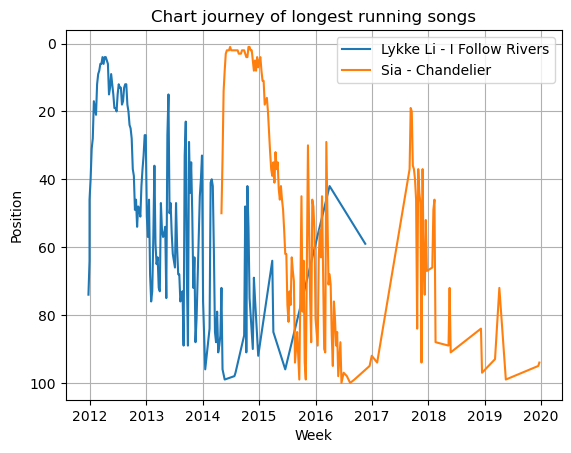

In [43]:
# Lykke Li 2011-2016
lykkeli_df = FRcharts_df[FRcharts_df['song_id'] == "i follow rivers-lykke li"]

# Sia 2014-2019
sia_df = FRcharts_df[FRcharts_df['song_id'] == "chandelier-sia"]

# Create a new figure and axes
fig, ax = plt.subplots()

# Plot the song's position evolution
ax.plot(lykkeli_df['chart_date'], lykkeli_df['Position'], label="Lykke Li - I Follow Rivers")
ax.plot(sia_df['chart_date'], sia_df['Position'], label="Sia - Chandelier")

# Set the labels, title and legend
ax.set_xlabel('Week')
ax.set_ylabel('Position')
ax.set_title('Chart journey of longest running songs')
ax.invert_yaxis() # position 1 should be on top
ax.legend()

# Display the plot
plt.grid(True)
plt.show()

In [44]:
sia_df


,Position,Position Evolution,Artist,Song Title,Year,Week,URL Week ID,song_id,chart_date,main_artist,artist_featured
118901,50,+119,Sia,Chandelier,2014,Semaine du 02 mai 2014,1419,chandelier-sia,2014-05-02,Sia,
118985,34,+16,Sia,Chandelier,2014,Semaine du 09 mai 2014,1420,chandelier-sia,2014-05-09,Sia,
119065,14,+20,Sia,Chandelier,2014,Semaine du 16 mai 2014,1421,chandelier-sia,2014-05-16,Sia,
119159,8,+6,Sia,Chandelier,2014,Semaine du 23 mai 2014,1422,chandelier-sia,2014-05-23,Sia,
119254,3,+5,Sia,Chandelier,2014,Semaine du 30 mai 2014,1423,chandelier-sia,2014-05-30,Sia,
...,...,...,...,...,...,...,...,...,...,...,...
143744,93,+29,Sia,Chandelier,2019,Semaine du 08 mars 2019,1911,chandelier-sia,2019-03-08,Sia,
144123,72,Entrée,Sia,Chandelier,2019,Semaine du 05 avril 2019,1915,chandelier-sia,2019-04-05,Sia,
144750,99,Entrée,Sia,Chandelier,2019,Semaine du 17 mai 2019,1921,chandelier-sia,2019-05-17,Sia,
147746,95,+8,Sia,Chandelier,2019,Semaine du 13 décembre 2019,1951,chandelier-sia,2019-12-13,Sia,


In [45]:
lykkeli_df

,Position,Position Evolution,Artist,Song Title,Year,Week,URL Week ID,song_id,chart_date,main_artist,artist_featured
106525,74,Entrée,Lykke Li,I Follow Rivers,2011,Semaine du 23 décembre 2011,1152,i follow rivers-lykke li,2011-12-23,Lykke Li,
106615,64,+10,Lykke Li,I Follow Rivers,2011,Semaine du 30 décembre 2011,1153,i follow rivers-lykke li,2011-12-30,Lykke Li,
106697,46,+18,Lykke Li,I Follow Rivers,2012,Semaine du 30 décembre 2011,1201,i follow rivers-lykke li,2011-12-30,Lykke Li,
106791,40,+6,Lykke Li,I Follow Rivers,2012,Semaine du 06 janvier 2012,1202,i follow rivers-lykke li,2012-01-06,Lykke Li,
106882,31,+9,Lykke Li,I Follow Rivers,2012,Semaine du 13 janvier 2012,1203,i follow rivers-lykke li,2012-01-13,Lykke Li,
...,...,...,...,...,...,...,...,...,...,...,...
123615,64,+69,Lykke Li,I Follow Rivers,2015,Semaine du 27 mars 2015,1514,i follow rivers-lykke li,2015-03-27,Lykke Li,
123736,85,-21,Lykke Li,I Follow Rivers,2015,Semaine du 03 avril 2015,1515,i follow rivers-lykke li,2015-04-03,Lykke Li,
124847,96,+49,Lykke Li,I Follow Rivers,2015,Semaine du 19 juin 2015,1526,i follow rivers-lykke li,2015-06-19,Lykke Li,
128593,42,+132,Lykke Li,I Follow Rivers,2016,Semaine du 01 avril 2016,1614,i follow rivers-lykke li,2016-04-01,Lykke Li,


## Importing own Last.fm Listening history (2006-2023)

In [46]:
lastfm_df = pd.read_csv('scrobbles-goodmornincaptn_230528.csv', sep=',')
lastfm_df.head()

,uts,utc_time,artist,artist_mbid,album,album_mbid,track,track_mbid
0,1685232463,"28 May 2023, 00:07",The Pines Of Rome,NaN,The Unstruck Bell,NaN,Siren,NaN
1,1685232136,"28 May 2023, 00:02",The Pines Of Rome,NaN,The Unstruck Bell,NaN,Beavertail Spoils,NaN
2,1685231904,"27 May 2023, 23:58",The Pines Of Rome,NaN,The Unstruck Bell,NaN,REDACTED,NaN
3,1685231629,"27 May 2023, 23:53",The Pines Of Rome,NaN,The Unstruck Bell,NaN,White Ships,NaN
4,1685231349,"27 May 2023, 23:49",The Pines Of Rome,NaN,The Unstruck Bell,NaN,Slick Enhancer,NaN


In [47]:
lastfm_df.tail()

,uts,utc_time,artist,artist_mbid,album,album_mbid,track,track_mbid
230751,1163883747,"18 Nov 2006, 21:02",Efterklang,8a7bed97-f080-4984-8db5-2ea5c82d8b33,Springer,2a19eed0-a234-3bf6-928b-4aa41621f1c0,Redrop,3b84e81e-9229-33c9-abc5-f62ad527af99
230752,1163883457,"18 Nov 2006, 20:57",Under Byen,35c81fab-bb3d-4198-a6bf-c9476054e6e6,Samme Stof Som Stof,2ed0a8d0-b645-423a-a73f-57f6b7a8b883,Den Her Sang Handler Om At Få Det Bedste Ud Af...,0e59570c-049a-3aec-8568-5dac0c170031
230753,1163883000,"18 Nov 2006, 20:50",TV on the Radio,eb872766-98f6-453d-883f-2ae908a18315,"Desperate Youth, Bloodthirsty Babes",NaN,Bomb Yourself,04772301-a172-37ec-bc64-b0a9fbb9623c
230754,1163882660,"18 Nov 2006, 20:44",Bugge Wesseltoft,a7835277-ab17-4506-a033-60f018757b84,FiLM iNG (New Conception of Jazz),NaN,hi lS?,888c77da-89c8-3d64-8d1c-d4e2a9f13282
230755,1163882017,"18 Nov 2006, 20:33",The Arcade Fire,NaN,NaN,NaN,Rebellion (Lies),44b8a05b-0f4e-4edb-86fd-d807eb9deb10


In [48]:
lastfm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230756 entries, 0 to 230755
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uts          230756 non-null  int64 
 1   utc_time     230756 non-null  object
 2   artist       230756 non-null  object
 3   artist_mbid  188817 non-null  object
 4   album        224517 non-null  object
 5   album_mbid   166022 non-null  object
 6   track        230756 non-null  object
 7   track_mbid   167945 non-null  object
dtypes: int64(1), object(7)
memory usage: 14.1+ MB


In [49]:
lastfm_df.nunique()

uts            229415
utc_time       225607
artist          10407
artist_mbid      6977
album           23059
album_mbid      12886
track           75282
track_mbid      55327
dtype: int64

In [50]:
# Concatenate "song_title" and "artist" columns to create "song_id"
#lastfm_df['song_id'] = lastfm_df['track'] + '-' + lastfm_df['artist']

# Clean the "song_id" values
#lastfm_df['artist'] = lastfm_df['song_id'].str.strip().str.capitalize()

last_unique_artists = lastfm_df['artist'].unique()
last_unique_artists = sorted(last_unique_artists)

print("Total unique artists:", len(last_unique_artists))
print(last_unique_artists)

#10407 unique artists before strip & capitalize same after so back to before


Total unique artists: 10407
['!!!', '((mothers))', "(Please) Don't Blame Mexico", '(Sandy) Alex G', '*Chi', '---__--___', '...', '...And You Will Know Us by the Trail of Dead', '.MUHARREM ÇOBAN', '.gif', '/A\\', '070 Shake', '1 2 3 4', '1 Mile North', '100 gecs', '1080p', '112', '13 & God', '1969 Collective', '1990s', '2 Chainz', '2 Mello', '2 orchestra', '21 Savage', '22', '2:54', '2Kilos&more', '2Pac', '2kilos &more', '2nd Grade', '3 Cohens', '31Knots', '32jnqwn-_-_-_', '33EMYBW', '3Phaz', '3rd Bass', '4s4ki', '4tRECk', '4th Alternative', '65daysofstatic', '66music', '6LACK', '6pm', '7 Year Bitch', '700 Bliss', '75 Dollar Bill', '77:78', '8. The Frozen Vaults', '90 Day Men', 'A B & the Sea', 'A Brand', 'A Burning Experience', 'A Camp', 'A Certain Ratio', 'A Dancing Beggar', 'A Fine Frenzy', 'A Flock of Seagulls', 'A Girl Called Eddy', 'A Grape Dope', 'A Grave With No Name', 'A Hawk and a Hacksaw', 'A Minor Forest', 'A Perfect Circle', 'A Place to Bury Strangers', 'A Silver Christmas'

In [51]:
LastFM_artist_counts = lastfm_df['artist'].value_counts()
Top20_LastFM_artist = LastFM_artist_counts.head(50)
Top20_LastFM_artist

Sufjan Stevens          1923
Björk                   1624
PJ Harvey               1361
Sonic Youth             1060
Perfume Genius          1000
My Brightest Diamond     913
Chris Garneau            909
Kate Bush                891
Grizzly Bear             807
Xiu Xiu                  781
Angel Olsen              778
The Notwist              770
Jenny Hval               736
Will Stratton            714
St. Vincent              689
Nils Frahm               682
David Bowie              669
Balmorhea                668
Mogwai                   645
Animal Collective        602
Blonde Redhead           594
Radiohead                562
Sharon Van Etten         555
Patrick Watson           552
Chelsea Wolfe            543
Ane Brun                 535
Son Lux                  533
Efterklang               526
Marissa Nadler           514
Deerhunter               507
Chad VanGaalen           495
Big Thief                489
DM Stith                 486
Fever Ray                480
Anna B Savage 

## Aggregating data sources

In [52]:
# Get unique artists from hot100_df and FRcharts_df
unique_artists = list(hot100_df['performer'].unique()) + list(FRcharts_df['Artist'].unique()) + list(lastfm_df['artist'].unique())

# Remove duplicates, turn to string all artist names (some were previously float), sort the list
unique_artists = list(set(unique_artists))
unique_artists = [str(element) for element in unique_artists]
unique_artists = sorted(unique_artists)

print("Total unique artists:", len(unique_artists))
print(unique_artists)

# Hot 100 + Top FR = 14865
# + Last.fm = 24321

Total unique artists: 24321
['!!!', '"Groove" Holmes', '"Little" Jimmy Dickens', '"Pookie" Hudson', '"Weird Al" Yankovic', '$-Crew', '$-crew', '$NOT & A$AP Rocky', "'N Sync", "'N Sync & Gloria Estefan", "'N Sync Featuring Nelly", "'Til Tuesday", '((mothers))', '(+44)', "(Please) Don't Blame Mexico", '(Sandy) Alex G', '(The Preacher) Bobby Womack', '*Chi', '---__--___', '-M-', '...', '...And You Will Know Us by the Trail of Dead', '.MUHARREM ÇOBAN', '.fun', '.gif', '/A\\', '0', '070 Shake', '1 2 3 4', '1 Mile North', '1 Of The Girls', '10 Years', '10,000 Maniacs', '100 Artistes Ensemble Contre Le Sida', '100 Proof Aged in Soul', '100 Strings and Jono (Choir of 40 Voices)', '100 gecs', '101 (One O One Electric Dream)', '1080p', '10cc', '112', '112 Featuring Foxy Brown', "112 Featuring Lil'z", '112 Featuring Ludacris', '112 Featuring Mase', '112 Featuring Super Cat', '112 Featuring The Notorious B.I.G.', '113', '113 feat. Black Renégat', '113 feat. Reda Taliani', '113, Magic System & Moha

In [53]:
# Get unique artists from hot100_df and FRcharts_df
unique_artists_chartsUSFR = list(hot100_df['main_artist'].unique()) + list(hot100_df['artist_featured'].unique()) + list(FRcharts_df['main_artist'].unique()) + list(FRcharts_df['artist_featured'].unique())

# Remove duplicates, turn to string all artist names (some were previously float), sort the list
unique_artists_chartsUSFR = list(set(unique_artists_chartsUSFR))
unique_artists_chartsUSFR = [str(element) for element in unique_artists_chartsUSFR]
unique_artists_chartsUSFR = sorted(unique_artists_chartsUSFR)

print("Total unique artists:", len(unique_artists_chartsUSFR))
print(unique_artists_chartsUSFR)

# Hot 100 + Top FR = 13567 (previously 14865 before processing featured artists)

Total unique artists: 13567
['', '"Boris"', '"Groove" Holmes', '"Little" Jimmy Dickens', '"Pookie" Hudson', '"Weird Al" Yankovic', '$-Crew', '$-crew', '$NOT & A$AP Rocky', "'N Sync", "'N Sync & Gloria Estefan", "'Til Tuesday", '(+44)', '(The Preacher) Bobby Womack', '-M-', '.fun', '0', '070 Shake', '1 Of The Girls', '10 Years', '10,000 Maniacs', '100 Artistes Ensemble Contre Le Sida', '100 Proof Aged in Soul', '100 Strings and Jono (Choir of 40 Voices)', '101 (One O One Electric Dream)', '10cc', '112', '113', '113, Magic System & Mohamed Lamine', '12 Gauge', '13 Block', '13 Organisé', '1789, Les Amants de la Bastille', '1910 Fruitgum Co.', '1927', '1995', '2 Be 3', '2 Chainz', '2 Chainz & B.o.B', '2 Chainz & Big Sean', '2 Chainz & Wiz Khalifa', '2 Chainz & Young Thug', '2 Chainz x Gucci Mane x Quavo', '2 Chainz, Big Sean & Nicki Minaj', '2 Chainz, Drake & Quavo', '2 Chainz, Meek Mill & Jeremih', '2 Eivissa', '2 Hyped Brothers & A Dog', '2 In A Room', '2 Of Clubs', '2 Pac', '2 Pistols',

In [54]:
# Find features, duos, etc.

# Define the keywords to search for
keywords = ['feat', 'feat\.', 'featuring', '&', ' and ', ' et ']

# Compile the regular expression pattern
pattern = re.compile(r'|'.join(keywords), re.IGNORECASE)

# Find artists that match the pattern
matched_artists = [artist for artist in unique_artists if re.search(pattern, artist)]

# Print the matched artists and the count
for artist in matched_artists:
    print(artist)

print("Total matched artists:", len(matched_artists))

#4997 artists with potential features, duos, etc in Billboard & Top 50 charts.
# (some are actual band names, so we can't strip the features all at once.
# Let's try to get info for all artists from Musicbrainz and deal after with those
# that remain unmatched)

# 5396 after adding Last.fm

$NOT & A$AP Rocky
'N Sync & Gloria Estefan
'N Sync Featuring Nelly
100 Strings and Jono (Choir of 40 Voices)
112 Featuring Foxy Brown
112 Featuring Lil'z
112 Featuring Ludacris
112 Featuring Mase
112 Featuring Super Cat
112 Featuring The Notorious B.I.G.
113 feat. Black Renégat
113 feat. Reda Taliani
113, Magic System & Mohamed Lamine
13 & God
13 Block Feat. Niska
2 Chainz & Wiz Khalifa
2 Chainz Featuring Ariana Grande
2 Chainz Featuring Drake
2 Chainz Featuring Drake & Lil Wayne
2 Chainz Featuring Kanye West
2 Chainz Featuring Kendrick Lamar
2 Chainz Featuring Lil Wayne
2 Chainz Featuring Pharrell
2 Chainz Featuring Travis Scott
2 Chainz Featuring Ty Dolla $ign, Trey Songz & Jhene Aiko
2 Chainz Featuring YG & Offset
2 Chainz, Drake & Quavo
2 Hyped Brothers & A Dog
2 Pac feat. Dr. Dre
2 Pac feat. KC and JoJo
2 Pistols Featuring T-Pain & Tay Dizm
20 Fingers Featuring Gillette
20 Fingers feat. Gillette
20 Fingers feat. Roula
21 Savage & Metro Boomin
21 Savage & Metro Boomin Featuring Dra

In [55]:
# Find featuring to keep only main artist (or split to keep the featured?)

# Define the keywords to search for
keywords = ['feat', 'feat\.', 'featuring']

# Compile the regular expression pattern
pattern = re.compile(r'|'.join(keywords), re.IGNORECASE)

# Find artists that match the pattern
matched_artists = [artist for artist in unique_artists_chartsUSFR if re.search(pattern, artist)]

# Print the matched artists and the count
for artist in matched_artists:
    print(artist)

print("Total matched artists:", len(matched_artists))

#3091 artists with features in Billboard & Top 50 charts.


Total matched artists: 0


In [56]:
# Define the keywords to search for
keywords = ['feat', 'feat\.', 'featuring']

# Compile the regular expression pattern
pattern = re.compile(r'|'.join(keywords), re.IGNORECASE)
parentheses_pattern_main = re.compile(r'\s*\($')
brackets_pattern_main = re.compile(r'\s*\[$')
parentheses_pattern_featured = re.compile(r'([^()\[\]]+)\s*[)\]]+$')

# Method 1: Keep only the main artist
cleaned_artists_main = []
featured_artists = []
for artist in unique_artists_chartsUSFR:
    match = re.search(pattern, artist)
    if match:
        cleaned_artist = artist[:match.start()].strip()
        cleaned_artist = re.sub(parentheses_pattern_main, '', cleaned_artist).strip()
        cleaned_artist = re.sub(brackets_pattern_main, '', cleaned_artist).strip()
        cleaned_artists_main.append(cleaned_artist)
    else:
        cleaned_artists_main.append(artist)

# Method 2: Keep the featured artists
cleaned_artists_featured = []
for artist in unique_artists_chartsUSFR:
    match = re.search(pattern, artist)
    if match:
        featured_artist = re.sub(pattern, '', artist[match.end():]).strip('. ').lstrip('uring ')
        cleaned_artists_featured.append(featured_artist)


# Print the results
print("Method 1: Keep only the main artist")
print("-----")
for artist in cleaned_artists_main:
    print(artist)

print("-------------------------------------")
print("\nMethod 2: Keep the featured artists")
for artist in cleaned_artists_featured:
    print(artist)

print("-------------------------------------")
print("\nTotal unique artists:", len(unique_artists_chartsUSFR))
print("Total cleaned artists (Method 1):", len(cleaned_artists_main))
print("Total featured artists (Method 2):", len(cleaned_artists_featured))

#Total matched artists: 14865
#Total cleaned artists (Method 1): 14865
#Total featured artists (Method 2): 3091

Method 1: Keep only the main artist
-----

"Boris"
"Groove" Holmes
"Little" Jimmy Dickens
"Pookie" Hudson
"Weird Al" Yankovic
$-Crew
$-crew
$NOT & A$AP Rocky
'N Sync
'N Sync & Gloria Estefan
'Til Tuesday
(+44)
(The Preacher) Bobby Womack
-M-
.fun
0
070 Shake
1 Of The Girls
10 Years
10,000 Maniacs
100 Artistes Ensemble Contre Le Sida
100 Proof Aged in Soul
100 Strings and Jono (Choir of 40 Voices)
101 (One O One Electric Dream)
10cc
112
113
113, Magic System & Mohamed Lamine
12 Gauge
13 Block
13 Organisé
1789, Les Amants de la Bastille
1910 Fruitgum Co.
1927
1995
2 Be 3
2 Chainz
2 Chainz & B.o.B
2 Chainz & Big Sean
2 Chainz & Wiz Khalifa
2 Chainz & Young Thug
2 Chainz x Gucci Mane x Quavo
2 Chainz, Big Sean & Nicki Minaj
2 Chainz, Drake & Quavo
2 Chainz, Meek Mill & Jeremih
2 Eivissa
2 Hyped Brothers & A Dog
2 In A Room
2 Of Clubs
2 Pac
2 Pistols
2 Unlimited
2-4 Family
20 Fingers
20 Years After
21 Savage
21 Savage & 42 Dugg
21 Savage & Baby Tate
21 Savage & Metro Boomin
21 Savage & Proj

In [57]:
# Previous ERRORS
# Check that they have been cleaned
# "BLACKstreet (" or "Babyface (", "Changing Faces (", "Das EFX (", "Dis L'Heure 2 Zouk (Lynnsha - Sweety", "Do Or Die (, "E-40 (" 4353 empty, Giorgio Moroder (, Glenn Medeiros (, Immature (, Jesse Johnson (, Keith Sweat (, L.F.O. (Lyte Funky Ones) (, Linda Ronstadt (, Ol Skool [, Or-N-More (, Patrick Swayze (, Puff Daddy & The Family (, Puff Daddy (, Quincy Jones (, R. Kelly Or Bow Wow (, SWV (, Seals & Crofts (, Shabba Ranks (, Shaggy (, Soul II Soul (, Stacy Earl (, Subway (, The Cantina Band (, The Lox [, The Miracles (, The Ovations (, The Poppy Family (, Veronica (

## Create Artist table, get Gender & other info from Musicbrainz API

### Fetch Artist info (type, gender, mbid, area, begin/end dates, tags (incl. genres))

In [9]:
# Set up the Musicbrainz API from .env

musicbrainz_app = os.environ['musicbrainz_app']
musicbrainz_ver = os.environ['musicbrainz_ver']
musicbrainz_mail = os.environ['musicbrainz_mail']

musicbrainzngs.set_useragent(musicbrainz_app, musicbrainz_ver, musicbrainz_mail)

In [59]:
# Sample test: Get the 10 most recurring artists in each list 
artist_test = list(hot100_df['performer'].value_counts().head(10).index) + list(FRcharts_df['Artist'].value_counts().head(10).index) + list(lastfm_df['artist'].value_counts().head(10).index)

# Remove duplicates, sort the list
artist_test = list(set(artist_test))
artist_test = sorted(artist_test)

print("Number artists in test:", len(artist_test))
print(artist_test)

Number artists in test: 29
['Björk', 'Chris Garneau', 'Céline Dion', 'David Guetta', 'Drake', 'Ed Sheeran', 'Elton John', 'Grizzly Bear', 'Johnny Hallyday', 'Kate Bush', 'Keith Urban', 'Kenny Chesney', 'Lady Gaga', 'Madonna', 'Mariah Carey', 'Maître Gims', 'My Brightest Diamond', 'Mylène Farmer', 'PJ Harvey', 'Perfume Genius', 'Rihanna', 'Rod Stewart', 'Sonic Youth', 'Soprano', 'Stevie Wonder', 'Sufjan Stevens', 'Taylor Swift', 'Tim McGraw', 'Xiu Xiu']


In [60]:
def fetch_artist_info(artist):
    result = musicbrainzngs.search_artists(artist=artist, limit=1)

    if 'artist-list' in result:
        artists = result['artist-list']
        if artists:
            artist_info = artists[0]
            artist_name = artist_info['name']

            # Get the artist's MusicBrainz ID
            mbid = artist_info['id']

            # Retrieve additional information using the MusicBrainz ID
            artist_details = musicbrainzngs.get_artist_by_id(mbid, includes=['tags', 'release-groups'])

            # Get the artist's type, gender, area, begin and end dates
            artist_type = artist_details['artist'].get('type')
            artist_gender = artist_details['artist'].get('gender')
            artist_area = artist_details['artist'].get('area', {}).get('name')

            # Get the artist's genres tags (with counts)
            genre_tags = []
            if 'tag-list' in artist_details['artist']:
                tags = artist_details['artist']['tag-list']
                for tag in tags:
                    tag_name = tag['name']
                    genre_tags.append(tag_name)
                    
            #if 'genre-list' in artist_details['artist']:
            #genres = artist_details['artist']['genre-list']
            #for genre in genres:
            #    tag = genre['name']
            #    count = genre['count']
            #    genre_tags.append({'tag': tag, 'count': count})

            #genres = artist_details['artist'].get('tag-list', [])
            #artist_genres = [(genre['name'], genre['count']) for genre in genres]

            # Get the artist's other tags (with counts)
            other_tags = []
            if 'user-tag-list' in artist_details['artist']:
                tags = artist_details['artist']['user-tag-list']
                for tag in tags:
                    tag_name = tag['name']
                    other_tags.append(tag_name)
                    #tag_count = tag['count']
                    #other_tags.append({'tag': tag_name, 'count': tag_count})

            # Get the artist's begin and end dates if available
            if 'life-span' in artist_details['artist']:
                artist_life_span = artist_details['artist']['life-span']
                artist_begin_date = artist_life_span.get('begin')
                artist_end_date = artist_life_span.get('end')
            else:
                artist_begin_date = None
                artist_end_date = None
                
            # Create a dictionary with the artist information
            artist_info_dict = {
                'Artist': artist_name,
                'MusicBrainz ID': mbid,
                'Type': artist_type,
                'Gender': artist_gender,
                'Area': artist_area,
                'Begin Date': artist_begin_date,
                'End Date': artist_end_date,
                'Genres': genre_tags,
                'Other Tags': other_tags
            }

            return artist_info_dict

    return None

In [61]:
# MUSIC BRAINZ API REQUESTS

###########################

# # Create an empty list to store the artist information
# artist_info_list = []
# 
# artist_test # OK (57 sec for 29 artists)
# batch1 = unique_artists_chartsUSFR[:100] #estim 3'17 OK
# batch2 = unique_artists_chartsUSFR[100:8000] #estim 4h18 OK ! export OK in expected time though VS code did seem to have crashed.
# batch3 = unique_artists_chartsUSFR[8000:9000] #estim ca. 33' export OK up to Patrick F
# batch4 = unique_artists_chartsUSFR[9000:9300] # estim ca. 10' export OK up to Point Blank
# batch5 = unique_artists_chartsUSFR[9300:9800] # larger batch crashed during lunch time / back to smaller batches export OK up to Ricoune
# batch6 = unique_artists_chartsUSFR[9800:10800] # export OK up to Slender
# batch7 = unique_artists_chartsUSFR[10800:11500] # export OK up to the Cardigans (23')
# batch8 = unique_artists_chartsUSFR[11500:12200] # export OK up to The Rubettes (23')
# batch9 = unique_artists_chartsUSFR[12200:12900] # export OK up to U2 (23')
# batch10 = unique_artists_chartsUSFR[12900:] # export OK! total len(unique_artists_chartsUSFR) = 13567
# 
# for artist in batch10:  
#     try:
#         artist_info_dict = fetch_artist_info(artist)
#         if artist_info_dict:
#             artist_info_list.append(artist_info_dict)
#             print(f"Scraped: {artist}")
#     except Exception as e:
#         print(f"ERROR scraping artist: {artist}. {str(e)}")
# 
# # Create a DataFrame from the artist information list
# artist_info_df = pd.DataFrame(artist_info_list)
# artist_info_df.to_csv('artist_info.csv', mode='a', header=not os.path.isfile('artist_info.csv'))
# 
# artist_info_df

### Importing previously scraped artist_info.csv

In [60]:
artist_info_df = pd.read_csv('artist_info.csv', sep=',', index_col=0)

In [61]:
artist_info_df.shape
#13495 rows

(13495, 9)

### Remove duplicates (from 13495 to 10754 artists)

In [62]:
#Remove duplicates
artist_info_df = artist_info_df.drop_duplicates(subset='MusicBrainz ID')
artist_info_df.shape
#now 10754 rows

(10754, 9)

### Import Musicbrainz Genres / TAGS & GENRES remain to be cleaned

In [63]:
artist_info_df = artist_info_df.rename(columns={'Genres': 'Tags'})
artist_info_df

,Artist,MusicBrainz ID,Type,Gender,Area,Begin Date,End Date,Tags,Other Tags
0,Boris,57652bf8-cfe8-42e7-b9a7-5572a7080d8d,Group,NaN,Japan,1992,NaN,"['ambient', 'dissonant', 'doom metal', 'drone'...",[]
1,Richard “Groove” Holmes,726cfe69-c905-4161-a10c-accb13d9ec26,Person,Male,United States,1931-05-02,1991-06-29,"['hard bop', 'jazz and blues', 'soul jazz']",[]
2,‘Little’ Jimmy Dickens,bd7589a3-f82f-4c3d-b7e2-e57e89552da1,Person,Male,United States,1920-12-19,2015-01-02,[],[]
3,Pookie Hudson,29dc9009-015f-47c4-bd17-ed2af6d2ae0c,Person,NaN,NaN,1934-06-11,2006-01-16,[],[]
4,“Weird Al” Yankovic,7746d775-9550-4360-b8d5-c37bd448ce01,Person,Male,United States,1959-10-23,NaN,"['accordion', 'american', 'comedy', 'comedy ro...",[]
...,...,...,...,...,...,...,...,...,...
655,À la recherche de la Nouvelle Star,46acab74-83fe-4d7a-90cd-fca626f229fb,NaN,NaN,France,NaN,NaN,[],[]
656,Ärsenik,201ac6bb-c268-4e9d-9390-5305512d5ee2,Group,NaN,France,1992,NaN,['hip hop'],[]
657,É o Tchan,04611209-2171-4652-98cd-e2c5e536ac04,Group,NaN,Brazil,1992,NaN,[],[]
660,Émilie Simon,01252145-c9e8-4de5-a480-9b2bed05450a,Person,Female,France,1978-07-17,NaN,"['arranger', 'arrangeur', 'composer', 'composi...",[]


In [64]:
artist_info_df = artist_info_df.rename(columns={'Other Tags': 'Genres'})


In [65]:
genres_df = pd.read_csv('musicbrainz_genres.csv', sep=',', index_col=None)
genres_df.head()

,Genres
0,2 tone
1,2-step
2,aak
3,abhang
4,aboio


In [89]:
# Iterate through the rows
for index, row in artist_info_df.iterrows():
    # Compare Tags with MusicBrainz genre list
    tags = row['Tags']
    genres = []

    # Add tag to genres list if found in MB's genres
    for tag in tags:
        if tag in genres_df['Genres'].values:
            genres.append(tag)

    # Move genres to the "Genre" column and remove them from "Tags"
    artist_info_df.at[index, 'Genres'] = genres
    artist_info_df.at[index, 'Tags'] = [tag for tag in tags if tag not in genres]


# Rename "Tags" column to "Other Tags"
artist_info_df = artist_info_df.rename(columns={'Tags': 'Other Tags'})


artist_info_df

ValueError: could not broadcast input array from shape (0,) into shape (6,)

In [98]:
for index, row in artist_info_df.iterrows():
    # Compare Tags with MusicBrainz genre list
    tags = row['Tags']
    genres = []

    # Add tag to genres list if found in MB's genres
    for tag in tags:
        if tag in genres_df['Genres'].values:
            genres.append(tag)

    # Move genres to the "Genre" column and remove them from "Tags"
    artist_info_df.loc[index, 'Genres'] = ', '.join(genres) if genres else ''  # Convert genres list to string

    # Create a list of filtered tags
    filtered_tags = [tag for tag in tags if tag not in genres]

    # Pad the filtered tags list with empty strings to match the size of the original 'Tags' column
    padded_tags = filtered_tags + [''] * (len(tags) - len(filtered_tags))

    # Assign the filtered tags back to the 'Tags' column, replacing the original values
    artist_info_df.loc[index, 'Tags'] = padded_tags

# Rename "Tags" column to "Other Tags"
artist_info_df = artist_info_df.rename(columns={'Tags': 'Other Tags'})

ValueError: could not broadcast input array from shape (232,) into shape (6,)

In [ ]:
#Store the test for reference before scraping at larger scale! Wish me luck!
#test_mb_df = artist_info_df
test_mb_df

,Artist,MusicBrainz ID,Type,Gender,Area,Begin Date,End Date,Other Tags,Genres
0,Björk,87c5dedd-371d-4a53-9f7f-80522fb7f3cb,Person,Female,Iceland,1965-11-21,None,"[a cappella, alternative, favoritos, icelandic]","[alternative pop, ambient, art pop, baroque po..."
1,Chris Garneau,bbc6f655-5d45-45bd-8553-cfd012178590,Person,Male,United States,1982-11-05,None,"[dreamamericana, psychedelia]","[baroque pop, gospel, pop, singer-songwriter, ..."
2,Céline Dion,847e8a0c-cc20-4213-9e16-975515c2a926,Person,Female,Canada,1968-03-30,None,"[adult contemporary, canadian, chanson, french...","[chanson française, pop, soft rock]"
3,David Guetta,302bd7b9-d012-4360-897a-93b00c855680,Person,Male,France,1967-11-07,None,[english],"[dance, dance-pop, edm, electro house, electro..."
4,Drake,9fff2f8a-21e6-47de-a2b8-7f449929d43f,Person,Male,Canada,1986-10-24,None,"[2010s, 2020s, alternative r&b, luxury rap, ra...","[contemporary r&b, hip hop, pop rap, r&b, trap]"
5,Ed Sheeran,b8a7c51f-362c-4dcb-a259-bc6e0095f0a6,Person,Male,United Kingdom,1991-02-17,None,"[2010s, guitarist, music for soccer moms, sing...","[dance-pop, folk, folk pop, pop, singer-songwr..."
6,Elton John,b83bc61f-8451-4a5d-8b8e-7e9ed295e822,Person,Male,United Kingdom,1947-03-25,None,"[2008 universal fire victim, adult contemporar...","[piano rock, pop, pop rock, rock, rock and rol..."
7,Grizzly Bear,59a7fbcb-ff74-494d-abd0-9c82359040c9,Group,None,United States,2002,None,[],"[art rock, indie folk, indie rock, neo-psyched..."
8,Johnny Hallyday,323ed974-8bf6-4f54-9525-b774a659f805,Person,Male,France,1943-06-15,2017-12-06,"[chanson, european, french, french pop, rock &...","[pop, pop rock, rock, yé-yé]"
9,Kate Bush,4b585938-f271-45e2-b19a-91c634b5e396,Person,Female,England,1958-07-30,None,"[alternative, british]","[alternative rock, ambient pop, art pop, art r..."


In [ ]:
# # Create an empty list to store all genre tags
# all_genre_tags = []
# 
# # Iterate over each row in the result DataFrame
# for index, row in artist_info_df.iterrows():
#     # Access the 'Genres' column for each row and extend the list of genre tags
#     all_genre_tags.extend(row['Tags'])
# 
# #Convert to set to remove duplicates
# all_genre_tags = set(all_genre_tags)
# 
# #Turn back into a list and sort
# genre_list = [elem for elem in all_genre_tags]
# genre_list = sorted(genre_list)
# genre_list

['1990s',
 '2000s',
 '2008 universal fire victim',
 '2010s',
 '2020s',
 '80s',
 '90s',
 'a cappella',
 'adult contemporary',
 'alternative',
 'alternative pop',
 'alternative r&b',
 'alternative rock',
 'ambient',
 'ambient pop',
 'americana',
 'art pop',
 'art rock',
 'barbadian',
 'baroque pop',
 'blues rock',
 'british',
 'bro-country',
 'canadian',
 'chamber folk',
 'chamber pop',
 'chanson',
 'chanson française',
 'christmas music',
 'classic rock',
 'contemporary country',
 'contemporary folk',
 'contemporary r&b',
 'country',
 'country pop',
 'crossover prog',
 'dance',
 'dance-pop',
 'dancehall',
 'disco',
 'downtempo',
 'dreamamericana',
 'edm',
 'electro house',
 'electronic',
 'electronica',
 'electropop',
 'english',
 'eurodance',
 'european',
 'europop',
 'experimental',
 'experimental rock',
 'favoritos',
 'female vocals',
 'film soundtrack',
 'folk',
 'folk pop',
 'folk rock',
 'folktronica',
 'french',
 'french hip hop',
 'french house',
 'french language',
 'french pop

## Fetch Artist Bio from Last.FM API

In [8]:
# Set up API key from .env

last_api_key = os.environ['last_api_key']

In [ ]:
# Fetch artist bios from Last.fm, using their musicbrainz ID (mbid)

# artist_bios = []  # List to store the retrieved artist bios
# 
# 
# for index, mbid in enumerate(list_artist_mbids[0:10]):
#     try:
#         artist = artist_info_df.loc[index, 'Artist']
#         
#         # Send a request to the Last.fm API to retrieve the artist's bio
#         url = f'http://ws.audioscrobbler.com/2.0/?method=artist.getinfo&mbid={mbid}&api_key={last_api_key}&format=json'
#         response = requests.get(url)
#         data = json.loads(response.text)
#         
#         if 'artist' in data:
#             artist_bio = data['artist']['bio']['content']
#             artist_bios.append({'Artist': artist, 'MBID': mbid, 'Bio': artist_bio})
#         else:
#             artist_bios.append({'Artist': artist, 'MBID': mbid, 'Bio': None})  # Append None if artist not found or bio not available
#     
#         print(f"Scraped bio for artist {index+1}/{len(list_artist_mbids[0:10])}")
#     
#     except Exception as e:
#         print(f"Error retrieving bio for artist {artist} (MBID: {mbid}): {str(e)}")
#         artist_bios.append({'Artist': artist, 'MBID': mbid, 'Bio': None})  # Append None in case of any error
# 
# # Create a new DataFrame from the artist_bios list
# artist_bios_df = pd.DataFrame(artist_bios)
# 
# # Export the DataFrame to a JSON file
# artist_bios_df.to_json('artist_bios.json', orient='records')

# Export the Dataframe to a CSV file
# artist_bios_df.to_csv('artist_bios.csv', index=False)

### Import previously fetched bios

In [67]:
artist_bios_df = pd.read_csv('artist_bios.csv', sep=',', index_col=0)

In [68]:
artist_bios_df

,Bio
MBID,
57652bf8-cfe8-42e7-b9a7-5572a7080d8d,There are at least two different artists using...
726cfe69-c905-4161-a10c-accb13d9ec26,"Richard Arnold ""Groove"" Holmes, Born Richard A..."
bd7589a3-f82f-4c3d-b7e2-e57e89552da1,"James Cecil Dickens (born December 19, 1920 - ..."
29dc9009-015f-47c4-bd17-ed2af6d2ae0c,"Thornton James (""Pookie"") Hudson ( born Des Mo..."
7746d775-9550-4360-b8d5-c37bd448ce01,"Alfred Matthew ""Weird Al"" Yankovic (born Octob..."
...,...
8cda32b5-1447-4ded-8a0e-f1cf8e6b3480,Élodie Frégé won France's Star Academy in 200...
01252145-c9e8-4de5-a480-9b2bed05450a,Émilie Simon is a French singer and composer b...
1e0de31c-4957-4649-9aa3-7b0f1d9d2c84,"Étienne Daho (born January 14, 1956 in Oran, A..."


### Remove duplicates (from 13495 artists to 10754)

In [69]:
artist_bios_df = artist_bios_df.reset_index().drop_duplicates(subset=['MBID']).set_index('MBID')
artist_bios_df

,Bio
MBID,
57652bf8-cfe8-42e7-b9a7-5572a7080d8d,There are at least two different artists using...
726cfe69-c905-4161-a10c-accb13d9ec26,"Richard Arnold ""Groove"" Holmes, Born Richard A..."
bd7589a3-f82f-4c3d-b7e2-e57e89552da1,"James Cecil Dickens (born December 19, 1920 - ..."
29dc9009-015f-47c4-bd17-ed2af6d2ae0c,"Thornton James (""Pookie"") Hudson ( born Des Mo..."
7746d775-9550-4360-b8d5-c37bd448ce01,"Alfred Matthew ""Weird Al"" Yankovic (born Octob..."
...,...
46acab74-83fe-4d7a-90cd-fca626f229fb,NaN
201ac6bb-c268-4e9d-9390-5305512d5ee2,"Ärsenik is a french rap duo, founded in 1997, ..."
04611209-2171-4652-98cd-e2c5e536ac04,É o Tchan! (not to be confused with the ghetto...


In [70]:
artist_bios_df.columns

Index(['Bio'], dtype='object')

## Merging all Artist info

In [71]:
artist_info_df

,Artist,MusicBrainz ID,Type,Gender,Area,Begin Date,End Date,Tags,Genres
0,Boris,57652bf8-cfe8-42e7-b9a7-5572a7080d8d,Group,NaN,Japan,1992,NaN,"['ambient', 'dissonant', 'doom metal', 'drone'...",[]
1,Richard “Groove” Holmes,726cfe69-c905-4161-a10c-accb13d9ec26,Person,Male,United States,1931-05-02,1991-06-29,"['hard bop', 'jazz and blues', 'soul jazz']",[]
2,‘Little’ Jimmy Dickens,bd7589a3-f82f-4c3d-b7e2-e57e89552da1,Person,Male,United States,1920-12-19,2015-01-02,[],[]
3,Pookie Hudson,29dc9009-015f-47c4-bd17-ed2af6d2ae0c,Person,NaN,NaN,1934-06-11,2006-01-16,[],[]
4,“Weird Al” Yankovic,7746d775-9550-4360-b8d5-c37bd448ce01,Person,Male,United States,1959-10-23,NaN,"['accordion', 'american', 'comedy', 'comedy ro...",[]
...,...,...,...,...,...,...,...,...,...
655,À la recherche de la Nouvelle Star,46acab74-83fe-4d7a-90cd-fca626f229fb,NaN,NaN,France,NaN,NaN,[],[]
656,Ärsenik,201ac6bb-c268-4e9d-9390-5305512d5ee2,Group,NaN,France,1992,NaN,['hip hop'],[]
657,É o Tchan,04611209-2171-4652-98cd-e2c5e536ac04,Group,NaN,Brazil,1992,NaN,[],[]
660,Émilie Simon,01252145-c9e8-4de5-a480-9b2bed05450a,Person,Female,France,1978-07-17,NaN,"['arranger', 'arrangeur', 'composer', 'composi...",[]


In [72]:
artist_info_with_bio = pd.merge(artist_info_df, artist_bios_df, how='left', left_on="MusicBrainz ID", right_on="MBID")
artist_info_with_bio

,Artist,MusicBrainz ID,Type,Gender,Area,Begin Date,End Date,Tags,Genres,Bio
0,Boris,57652bf8-cfe8-42e7-b9a7-5572a7080d8d,Group,NaN,Japan,1992,NaN,"['ambient', 'dissonant', 'doom metal', 'drone'...",[],There are at least two different artists using...
1,Richard “Groove” Holmes,726cfe69-c905-4161-a10c-accb13d9ec26,Person,Male,United States,1931-05-02,1991-06-29,"['hard bop', 'jazz and blues', 'soul jazz']",[],"Richard Arnold ""Groove"" Holmes, Born Richard A..."
2,‘Little’ Jimmy Dickens,bd7589a3-f82f-4c3d-b7e2-e57e89552da1,Person,Male,United States,1920-12-19,2015-01-02,[],[],"James Cecil Dickens (born December 19, 1920 - ..."
3,Pookie Hudson,29dc9009-015f-47c4-bd17-ed2af6d2ae0c,Person,NaN,NaN,1934-06-11,2006-01-16,[],[],"Thornton James (""Pookie"") Hudson ( born Des Mo..."
4,“Weird Al” Yankovic,7746d775-9550-4360-b8d5-c37bd448ce01,Person,Male,United States,1959-10-23,NaN,"['accordion', 'american', 'comedy', 'comedy ro...",[],"Alfred Matthew ""Weird Al"" Yankovic (born Octob..."
...,...,...,...,...,...,...,...,...,...,...
10749,À la recherche de la Nouvelle Star,46acab74-83fe-4d7a-90cd-fca626f229fb,NaN,NaN,France,NaN,NaN,[],[],NaN
10750,Ärsenik,201ac6bb-c268-4e9d-9390-5305512d5ee2,Group,NaN,France,1992,NaN,['hip hop'],[],"Ärsenik is a french rap duo, founded in 1997, ..."
10751,É o Tchan,04611209-2171-4652-98cd-e2c5e536ac04,Group,NaN,Brazil,1992,NaN,[],[],É o Tchan! (not to be confused with the ghetto...
10752,Émilie Simon,01252145-c9e8-4de5-a480-9b2bed05450a,Person,Female,France,1978-07-17,NaN,"['arranger', 'arrangeur', 'composer', 'composi...",[],Émilie Simon is a French singer and composer b...


### Data Cleaning

In [99]:
# Replace empty square brackets with NaN in 'Tags' column
artist_info_with_bio['Tags'] = artist_info_with_bio['Tags'].replace('[]', np.nan)

# Replace empty square brackets with NaN in 'Genres' column
artist_info_with_bio['Genres'] = artist_info_with_bio['Genres'].replace('[]', np.nan)

artist_info_with_bio

,Artist,MusicBrainz ID,Type,Gender,Area,Begin Date,End Date,Tags,Genres,Bio
0,Boris,57652bf8-cfe8-42e7-b9a7-5572a7080d8d,Group,NaN,Japan,1992,NaN,"['ambient', 'dissonant', 'doom metal', 'drone'...",NaN,There are at least two different artists using...
1,Richard “Groove” Holmes,726cfe69-c905-4161-a10c-accb13d9ec26,Person,Male,United States,1931-05-02,1991-06-29,"['hard bop', 'jazz and blues', 'soul jazz']",NaN,"Richard Arnold ""Groove"" Holmes, Born Richard A..."
2,‘Little’ Jimmy Dickens,bd7589a3-f82f-4c3d-b7e2-e57e89552da1,Person,Male,United States,1920-12-19,2015-01-02,NaN,NaN,"James Cecil Dickens (born December 19, 1920 - ..."
3,Pookie Hudson,29dc9009-015f-47c4-bd17-ed2af6d2ae0c,Person,NaN,NaN,1934-06-11,2006-01-16,NaN,NaN,"Thornton James (""Pookie"") Hudson ( born Des Mo..."
4,“Weird Al” Yankovic,7746d775-9550-4360-b8d5-c37bd448ce01,Person,Male,United States,1959-10-23,NaN,"['accordion', 'american', 'comedy', 'comedy ro...",NaN,"Alfred Matthew ""Weird Al"" Yankovic (born Octob..."
...,...,...,...,...,...,...,...,...,...,...
10749,À la recherche de la Nouvelle Star,46acab74-83fe-4d7a-90cd-fca626f229fb,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN
10750,Ärsenik,201ac6bb-c268-4e9d-9390-5305512d5ee2,Group,NaN,France,1992,NaN,['hip hop'],NaN,"Ärsenik is a french rap duo, founded in 1997, ..."
10751,É o Tchan,04611209-2171-4652-98cd-e2c5e536ac04,Group,NaN,Brazil,1992,NaN,NaN,NaN,É o Tchan! (not to be confused with the ghetto...
10752,Émilie Simon,01252145-c9e8-4de5-a480-9b2bed05450a,Person,Female,France,1978-07-17,NaN,"['arranger', 'arrangeur', 'composer', 'composi...",NaN,Émilie Simon is a French singer and composer b...


In [104]:
# artist_info_with_bio.to_csv('artist_info_with_bio.csv', index=False)

#### Drop anonymous artists

In [106]:
mask = (artist_info_with_bio['Artist'] == '[no artist]') | (artist_info_with_bio['Artist'] == '[anonymous]')
artists_to_drop = artist_info_with_bio[mask]
artists_to_drop

,Artist,MusicBrainz ID,Type,Gender,Area,Begin Date,End Date,Tags,Genres,Bio
6760,[no artist],eec63d3c-3b81-4ad4-b1e4-7c147d4d2b61,Other,Not applicable,NaN,NaN,NaN,"['do not merge', 'meta artist', 'special purpo...",NaN,This is probably mistagged for Wolfgang Amadeu...
8961,[anonymous],f731ccc4-e22a-43af-a747-64213329e088,Other,Not applicable,[Worldwide],NaN,NaN,"['anon', 'anonymous', 'special purpose', 'spec...",NaN,Gregorian is a German band headed by Frank Pet...


In [107]:
artist_info_with_bio.drop(artists_to_drop.index, inplace=True)

In [115]:
rows_to_display = artist_info_with_bio[artist_info_with_bio['Artist'].isin(['[no artist]', '[anonymous]'])]
print(rows_to_display)

Empty DataFrame
Columns: [Artist, MusicBrainz ID, Type, Gender, Area, Begin Date, End Date, Tags, Genres, Bio]
Index: []


In [73]:
artist_info_with_bio.columns

Index(['Artist', 'MusicBrainz ID', 'Type', 'Gender', 'Area', 'Begin Date',
       'End Date', 'Tags', 'Genres', 'Bio'],
      dtype='object')

In [116]:
artist_info_with_bio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10752 entries, 0 to 10753
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Artist          10752 non-null  object 
 1   MusicBrainz ID  10752 non-null  object 
 2   Type            10111 non-null  object 
 3   Gender          5593 non-null   object 
 4   Area            9126 non-null   object 
 5   Begin Date      7975 non-null   object 
 6   End Date        2258 non-null   object 
 7   Tags            5954 non-null   object 
 8   Genres          0 non-null      float64
 9   Bio             7837 non-null   object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


In [117]:
artist_info_with_bio.nunique()

Artist            10751
MusicBrainz ID    10752
Type                  6
Gender                5
Area                300
Begin Date         4620
End Date           1227
Tags               4093
Genres                0
Bio                7808
dtype: int64

In [118]:
gender_counts = artist_info_with_bio['Gender'].value_counts()
print(gender_counts)

Male              3854
Female            1727
Non-binary           7
Other                3
Not applicable       2
Name: Gender, dtype: int64


In [119]:
nan_bio_counts = artist_info_with_bio[artist_info_with_bio['Gender'].isin(['Male', 'Female', 'Non-binary'])]['Bio'].isna().sum()
print(nan_bio_counts)

1342


In [121]:
female_nan_bio_count = artist_info_with_bio.loc[artist_info_with_bio['Gender'] == 'Female', 'Bio'].isna().sum()
print(female_nan_bio_count)

388


## Merging Songs and artist info

In [75]:
hot100_df.shape

NameError: name 'hot100_df' is not defined

In [ ]:
artist_info_df.shape

(10754, 9)

In [ ]:
hot100_with_artist_info = pd.merge(hot100_df, artist_info_df, how='left', left_on="main_artist", right_on="Artist")
hot100_with_artist_info

,chart_position,chart_date,song,performer,instance,time_on_chart,consecutive_weeks,previous_week,peak_position,worst_position,...,artist_featured,Artist,MusicBrainz ID,Type,Gender,Area,Begin Date,End Date,Tags,Genres
0,84,1990-05-05,"""B"" Girls",Young And Restless,1.0,1,NaN,NaN,84,84,...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,78,1990-05-12,"""B"" Girls",Young And Restless,1.0,2,1.0,84.0,78,84,...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,68,1990-05-19,"""B"" Girls",Young And Restless,1.0,3,2.0,78.0,68,84,...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,60,1990-05-26,"""B"" Girls",Young And Restless,1.0,4,3.0,68.0,60,84,...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,58,1990-06-02,"""B"" Girls",Young And Restless,1.0,5,4.0,60.0,58,84,...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336351,99,2001-02-10,www.memory,Alan Jackson,1.0,15,14.0,89.0,45,99,...,,Alan Jackson,7291957b-c463-4275-a41c-a104c9e2337f,Person,Male,United States,1958-10-17,NaN,"['bluegrass', 'christmas music', 'contemporary...",[]
336352,66,1958-12-13,¿Dònde Està Santa Claus? (Where Is Santa Claus?),Augie Rios,1.0,1,NaN,NaN,66,66,...,,Augie Rios,03a62df3-6ca1-4edc-9daa-cf6cae086f3c,NaN,NaN,NaN,NaN,NaN,[],[]
336353,53,1958-12-20,¿Dònde Està Santa Claus? (Where Is Santa Claus?),Augie Rios,1.0,2,1.0,66.0,53,66,...,,Augie Rios,03a62df3-6ca1-4edc-9daa-cf6cae086f3c,NaN,NaN,NaN,NaN,NaN,[],[]
336354,47,1958-12-27,¿Dònde Està Santa Claus? (Where Is Santa Claus?),Augie Rios,1.0,3,2.0,53.0,47,66,...,,Augie Rios,03a62df3-6ca1-4edc-9daa-cf6cae086f3c,NaN,NaN,NaN,NaN,NaN,[],[]


!!!! Left join: From 336295 to 336356 rows ???!!!???? (61 unexpected rows)

In [ ]:
hot100_with_artist_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336356 entries, 0 to 336355
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   chart_position     336356 non-null  int64  
 1   chart_date         336356 non-null  object 
 2   song               336356 non-null  object 
 3   performer          336356 non-null  object 
 4   instance           336356 non-null  float64
 5   time_on_chart      336356 non-null  int64  
 6   consecutive_weeks  303043 non-null  float64
 7   previous_week      303043 non-null  float64
 8   peak_position      336356 non-null  int64  
 9   worst_position     336356 non-null  int64  
 10  chart_debut        336356 non-null  object 
 11  chart_url          336356 non-null  object 
 12  song_id            336356 non-null  object 
 13  main_artist        336356 non-null  object 
 14  artist_featured    336356 non-null  object 
 15  Artist             272217 non-null  object 
 16  Mu

In [ ]:
# Replace empty square brackets with NaN in 'Tags' column
hot100_with_artist_info['Tags'] = hot100_with_artist_info['Tags'].replace('[]', np.nan)

# Replace empty square brackets with NaN in 'Genres' column
hot100_with_artist_info['Genres'] = hot100_with_artist_info['Genres'].replace('[]', np.nan)

hot100_with_artist_info

,chart_position,chart_date,song,performer,instance,time_on_chart,consecutive_weeks,previous_week,peak_position,worst_position,...,artist_featured,Artist,MusicBrainz ID,Type,Gender,Area,Begin Date,End Date,Tags,Genres
0,84,1990-05-05,"""B"" Girls",Young And Restless,1.0,1,NaN,NaN,84,84,...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,78,1990-05-12,"""B"" Girls",Young And Restless,1.0,2,1.0,84.0,78,84,...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,68,1990-05-19,"""B"" Girls",Young And Restless,1.0,3,2.0,78.0,68,84,...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,60,1990-05-26,"""B"" Girls",Young And Restless,1.0,4,3.0,68.0,60,84,...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,58,1990-06-02,"""B"" Girls",Young And Restless,1.0,5,4.0,60.0,58,84,...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336351,99,2001-02-10,www.memory,Alan Jackson,1.0,15,14.0,89.0,45,99,...,,Alan Jackson,7291957b-c463-4275-a41c-a104c9e2337f,Person,Male,United States,1958-10-17,NaN,"['bluegrass', 'christmas music', 'contemporary...",NaN
336352,66,1958-12-13,¿Dònde Està Santa Claus? (Where Is Santa Claus?),Augie Rios,1.0,1,NaN,NaN,66,66,...,,Augie Rios,03a62df3-6ca1-4edc-9daa-cf6cae086f3c,NaN,NaN,NaN,NaN,NaN,NaN,NaN
336353,53,1958-12-20,¿Dònde Està Santa Claus? (Where Is Santa Claus?),Augie Rios,1.0,2,1.0,66.0,53,66,...,,Augie Rios,03a62df3-6ca1-4edc-9daa-cf6cae086f3c,NaN,NaN,NaN,NaN,NaN,NaN,NaN
336354,47,1958-12-27,¿Dònde Està Santa Claus? (Where Is Santa Claus?),Augie Rios,1.0,3,2.0,53.0,47,66,...,,Augie Rios,03a62df3-6ca1-4edc-9daa-cf6cae086f3c,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
hot100_with_artist_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336356 entries, 0 to 336355
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   chart_position     336356 non-null  int64  
 1   chart_date         336356 non-null  object 
 2   song               336356 non-null  object 
 3   performer          336356 non-null  object 
 4   instance           336356 non-null  float64
 5   time_on_chart      336356 non-null  int64  
 6   consecutive_weeks  303043 non-null  float64
 7   previous_week      303043 non-null  float64
 8   peak_position      336356 non-null  int64  
 9   worst_position     336356 non-null  int64  
 10  chart_debut        336356 non-null  object 
 11  chart_url          336356 non-null  object 
 12  song_id            336356 non-null  object 
 13  main_artist        336356 non-null  object 
 14  artist_featured    336356 non-null  object 
 15  Artist             272217 non-null  object 
 16  Mu

In [ ]:
hot100_with_artist_info['Gender'].value_counts()

Male          119413
Female         52467
Non-binary      1034
Name: Gender, dtype: int64